In [1]:
def get_trading_date_n(date, idx_close, n, verbose=False):
  """
  This function takes a date, a closing price date index, a number of days (n), and an optional verbosity flag,
  and returns the trading date n days away from the input date if it exists in the index, or None otherwise.

  Args:
    date: The date to start from (as a datetime object).
    idx_close: A dictionary or Series containing date index of close prices.
    n: The number of days to move forward or backward in time (positive for future, negative for past).
    verbose: An optional flag to print additional information about the process (default: False).

  Returns:
    The trading date n days away from the input date if it exists in the index, or None otherwise.
  """

  # Check if the input date is present in the closing price index.
  if date in idx_close:
    # Get the last and current index positions of the input date.
    idx_last = len(idx_close) - 1  # Last index of the closing price index.
    idx_date = idx_close.get_loc(date)  # Index of the input date in the index.

    # Calculate the index of the date n days away from the input date.
    idx_date_n = idx_date + n

    # Print debug information if verbose flag is set.
    if verbose:
      print(f"date: {date} is in idx_close, "
            f"date's position in idx_close is: {idx_date} of {idx_last}, "
            f"n: {n}, idx_date_n: {idx_date_n},")

    # Check if the calculated index is within the bounds of the closing price index.
    if 0 <= idx_date_n <= idx_last:
      # Get the date n days away from the input date using the calculated index.
      date_n = idx_close[idx_date_n]

      # Print debug information if verbose flag is set.
      if verbose:
        print(f"idx_date_n: {idx_date_n} is within bounds of idx_close (0 to {idx_last}), date_n: {date_n}\n")

    else:
      # If the calculated index is out of bounds, set the output date to None.
      date_n = None

      # Print debug information if verbose flag is set.
      if verbose:
        print(f"idx_date_n: {idx_date_n} is out-of-bounds of idx_close (0 to {idx_last})\n")

  else:
    # If the input date is not in the closing price index, set the output date to None.
    date_n = None

    # Print debug information if verbose flag is set.
    if verbose:
      print(f"date: {date} is not in idx_close\n")

  # Return the date n days away from the input date if it exists in the index, or None otherwise.
  return date_n

In [2]:
def any_not_in_list(list1, list2):
  """
  Checks if any items in list1 are not in list2.

  Args:
    list1: A list of items.
    list2: Another list of items.

  Returns:
    True if any item in list1 is not in list2, False if all are present.
  """
  return bool(set(list1) - set(list2))

In [3]:
def is_date_in_close(date, df_close):
  """
  Checks if a given date is present in a DataFrame's index, considering only the date portion (YYYY-MM-DD).

  Args:
    date (str): The date to check in the format YYYY-MM-DD.
    df_close (pandas.DataFrame): A DataFrame containing a date index.

  Returns:
    str or None: The input date if it's found in the index, otherwise None.
  """  

  # Format the index to YYYY-MM-DD for comparison
  idx_close = df_close.index.strftime('%Y-%m-%d')

  # Check if the date is in the formatted index
  if date in idx_close:
    # Return the date if found
    return date
  else:
    # Return None if not found
    return None

In [4]:
def calc_portf_shares(df_close, date, str_symbols, portf_target):
  """
  Calculates the number of shares to buy for each symbol in a portfolio to meet a target investment value.

  Args:
    df_close (pandas.DataFrame): DataFrame with closing prices, indexed by date and symbols.
    date (str): The date for which to calculate shares.
    str_symbols (str): String representation of a list of symbols to include in the portfolio.
    portf_target (float): The total target investment value for the portfolio.

  Returns:
    numpy.ndarray: An array containing the number of shares to buy for each symbol.
  """

  # Import necessary libraries
  import numpy as np
  from ast import literal_eval

  # Convert string representation of symbols to a list
  l_syms = literal_eval(str_symbols)

  # Retrieve closing prices for the specified symbols on the given date
  ar_price = df_close.loc[date][l_syms].values

  # Calculate the number of symbols
  sym_cnt = len(l_syms)

  # Determine the target investment amount per symbol
  amt_per_sym = portf_target / sym_cnt

  # Calculate the number of shares to buy for each symbol, rounding down to whole shares
  ar_shares = np.floor(amt_per_sym / ar_price)

  return ar_shares

In [5]:
def calc_portf_value(df_close, date, str_symbols, ar_shares, verbose=False):
  """
  Calculates the total value of a portfolio of stocks for a given date.

  Args:
  df_close (pandas.DataFrame): DataFrame containing closing prices, indexed by date and symbols.
  date (str): The date for which to calculate the portfolio value.
  str_symbols (str): String representation of a list of symbols in the portfolio.
  ar_shares (numpy.ndarray): Array containing the number of shares held for each symbol.
  verbose (bool, optional): If True, prints details of the calculation. Defaults to False.

  Returns:
  tuple: A tuple containing the date, symbols, closing prices, shares, individual symbol values, and total portfolio value.
  """

  # Import necessary libraries
  import numpy as np
  from ast import literal_eval

  # Convert string representation of symbols to a list
  l_syms = literal_eval(str_symbols)

  # Retrieve closing prices for the specified symbols on the given date
  ar_price = df_close.loc[date][l_syms].values

  # Calculate the dollar value invested in each symbol
  ar_value = ar_price * ar_shares

  # Calculate the total portfolio value by summing the individual symbol values
  portf_value = sum(ar_value)

  # Print details if verbose is True
  if verbose:
    print(f'date = {date}, l_syms = {l_syms}, ar_price = {ar_price}, ar_shares = {ar_shares}, ar_value = {ar_value}, portf_value = {portf_value}')
    print(f'{date} {portf_value = }')

  # Return the calculated values
  return date, l_syms, ar_price, ar_shares, ar_value, portf_value

In [6]:
def calc_portf_value_date_buy(idx_date, str_symbols, df_close, portf_target, n, verbose=False):
  """
  Calculates portfolio values for multiple dates and symbol combinations, handling potential data gaps.

  Args:
  idx_date (list): List of dates (str) to evaluate portfolios.
  str_symbols (list): List of symbol lists (str) to evaluate for each date.
  df_close (pandas.DataFrame): DataFrame with closing prices, indexed by date and symbols.
  portf_target (float): Target portfolio value for allocation.
  n (int): Number of trading days to offset execution from the lookback date.
  verbose (bool, optional): If True, prints details. Defaults to False.

  Returns:
  tuple: Tuple containing lists of buy dates, shares, and portfolio values for both the selected symbols and SPY.
  """

  from ast import literal_eval

  # Extract trading dates and symbols from the DataFrame
  idx_close = df_close.index.strftime('%Y-%m-%d')  # Trading dates in format YYYY-MM-DD
  symbols_df_close = df_close.columns  # Symbols in df_close

  # Initialize lists to store results
  date_exec = []  # Buy date of portfolio
  shares_syms = []  # Lists of shares of each symbol bought on each date
  value_portf = []  # List of portfolio values on each date
  shares_SPY = []  # List of shares of SPY bought on each date
  value_SPY = []  # List of values of SPY shares on each date

  # Iterate through pairs of dates and symbol lists
  for date, syms in zip(idx_date, str_symbols):

    # Determine the execution date based on the lookback date and the offset n
    next_date_n = get_trading_date_n(date, idx_close, n, verbose=False)
    close_date_n = is_date_in_close(next_date_n, df_close)

    # Print information for debugging
    print(f'++++++++++++++')
    print(f'date: {date}')
    print(f'n: {n}')         
    print(f'next_date_n: {next_date_n}')
    print(f'close_date_n: {close_date_n}')
    print(f'syms: {syms}')
    print(f'++++++++++++++')    

    # Convert string representation of symbols back to a list
    l_syms = literal_eval(syms)

    # Check if any symbols are not present in the DataFrame
    sym_not_in_df_close = any_not_in_list(l_syms, symbols_df_close)

    if close_date_n is None or sym_not_in_df_close:
      # Handle missing data:
      print(f'l_syms: {l_syms}')  
      print(f'sym_not_in_df_close: {sym_not_in_df_close}')  

      p_date = None
      p_ar_shares = None
      p_portf_value = None  # Set to None when data are not available
      SPY_shares = None
      SPY_value = None  # Set to None when data are not available

      if verbose:
        print(f"No data for close_date_n {close_date_n}, pick's portf value = None")
        print(f'No data for close_date_n {close_date_n}, SPY portf value =    None')

    else:
      # Calculate portfolio values when data is available:
      p_ar_shares = calc_portf_shares(df_close, close_date_n, syms, portf_target)
      p_date, l_syms, ar_price, ar_shares, ar_value, p_portf_value = calc_portf_value(df_close, close_date_n, syms, p_ar_shares, verbose)

      syms = str(['SPY'])
      SPY_shares = calc_portf_shares(df_close, close_date_n, syms, portf_target)
      date, l_syms, ar_price, ar_shares, ar_value, SPY_value = calc_portf_value(df_close, close_date_n, syms, SPY_shares, verbose)

      if verbose:
        print(f"close_date_n pick's portf value = {p_portf_value}")
        print(f'close_date_n SPY portf value =    {SPY_value}')

    date_exec.append(p_date)
    shares_syms.append(p_ar_shares)
    value_portf.append(p_portf_value)
    shares_SPY.append(SPY_shares)
    value_SPY.append(SPY_value)

    print('='*20, '\n')

  return date_exec, shares_syms, value_portf, shares_SPY, value_SPY

In [7]:
def calc_portf_value_date_n(idx_date, str_symbols, df_close, my_portf_shares, my_SPY_shares, n, verbose=False):
  """
  Calculates portfolio values for multiple dates and symbol combinations, taking pre-determined shares as input.

  Args:
  idx_date (list): List of dates (str) to evaluate portfolios.
  str_symbols (list): List of symbol lists (str) to evaluate for each date.
  df_close (pandas.DataFrame): DataFrame with closing prices, indexed by date and symbols.
  my_portf_shares (list): List of lists of shares for each symbol combination.
  my_SPY_shares (list): List of shares of SPY to evaluate for each date.
  n (int): Number of trading days to offset execution from the lookback date.
  verbose (bool, optional): If True, prints details. Defaults to False.

  Returns:
  tuple: Tuple containing lists of buy dates, shares, and portfolio values for both the selected symbols and SPY.
  """

  # Extract trading dates from the DataFrame
  idx_close = df_close.index.strftime('%Y-%m-%d')  # Trading dates in format YYYY-MM-DD

  # Initialize lists to store results
  date_exec = []  # Buy date of portfolio
  shares_syms = []  # Lists of shares of each symbol bought on each date
  value_portf = []  # List of portfolio values on each date
  shares_SPY = []  # List of shares of SPY bought on each date
  value_SPY = []  # List of values of SPY shares on each date

  # Iterate through pairs of dates, symbol lists, and shares
  for date, symbols, portf_shares, SPY_shares in zip(idx_date, str_symbols, my_portf_shares, my_SPY_shares):

    # Determine the execution date based on the lookback date and the offset n
    next_date_n = get_trading_date_n(date, idx_close, n, verbose=False)
    close_date_n = is_date_in_close(next_date_n, df_close)

    if close_date_n is None or portf_shares is None:
      # Handle missing data or missing shares:
      p_date_exec = None
      p_ar_shares = None
      p_value_portf = None  # Set to None when data or shares are unavailable
      SPY_ar_shares = None
      SPY_value_portf = None  # Set to None when data or shares are unavailable

      if verbose:
        print(f"No data for close_date_n {close_date_n}, pick's portf value = None")

    else:
      # Calculate portfolio values when data and shares are available:
      p_date_exec, p_ar_syms, p_ar_price, p_ar_shares, p_ar_value, p_value_portf = calc_portf_value(df_close, close_date_n, symbols, portf_shares, verbose)

      SPY = str(['SPY'])  # Calculate SPY portfolio value separately
      SPY_date_exec, SPY_ar_syms, SPY_ar_price, SPY_ar_shares, SPY_ar_value, SPY_value_portf = calc_portf_value(df_close, close_date_n, SPY, SPY_shares, verbose)

      if verbose:
        print(f"next_date_n pick's portf value = {p_value_portf}")
        print(f'next_date_n SPY portf value =    {SPY_value_portf}')

    # Append results to lists
    date_exec.append(p_date_exec)
    shares_syms.append(p_ar_shares)
    value_portf.append(p_value_portf)
    shares_SPY.append(SPY_ar_shares)
    value_SPY.append(SPY_value_portf)

    print('='*20, '\n')

  return date_exec, shares_syms, value_portf, shares_SPY, value_SPY

In [8]:
"""
Imports libraries, sets display options, and defines file paths for stock analysis.
"""

import pandas as pd  # Library for data manipulation and analysis
import numpy as np  # Library for numerical operations and array manipulation
from myUtils import pickle_load, pickle_dump  # Functions for loading and saving data

# Set pandas display options for better readability
pd.set_option('display.max_rows', 100)  # Display up to 100 rows
pd.set_option('display.max_columns', 30)  # Display up to 30 columns
pd.set_option('display.max_colwidth', 30)  # Display columns with a maximum width of 30 characters
pd.set_option('display.width', 900)  # Set overall display width to 900 characters

# Define file paths for data storage and retrieval
path_dir = "C:/Users/ping/MyDrive/stocks/yfinance/"  # Base directory for stock data
path_data_dump = path_dir + "VSCode_dump/"  # Subdirectory for pickled data

# Define file names for specific datasets
# fp_df_picks = f'df_picks'  # (Commented out) Stock picks by criteria (CAGR/UI, CAGR/rtn_std, rtd/UI)
fp_df_model_top_picks = 'df_model_top_picks'  # Top stock picks from the model developed by backtesting
fp_df_close_clean = 'df_close_clean'  # Historic closing prices for stocks

# Set verbose mode for printing information during execution
verbose = True


In [9]:
"""
Loads pre-processed datasets from pickled files.
"""

# Load the DataFrame containing historical closing prices:
df_close = pickle_load(path_data_dump, fp_df_close_clean)  # Load from the specified pickle file

# Load the DataFrame containing top stock picks from the model:
df_picks_mp = pickle_load(path_data_dump, fp_df_model_top_picks)  # Load from the specified pickle file


In [10]:
"""
Extracts and prints information about the date range and length of the df_picks_mp DataFrame.
"""

# Extract dates from the DataFrame and sort them chronologically:
dates_sorted = sorted(df_picks_mp.date.tolist())  # Create a list of dates and sort them

# Extract the first and last dates to determine the date range:
date_start_picks_mp = dates_sorted[0]  # Get the earliest date
date_end_picks_mp = dates_sorted[-1]  # Get the latest date

# Print the date range and the number of rows in the DataFrame:
print(f'date_start_picks_mp: {date_start_picks_mp}')
print(f'date_end_picks_mp: {date_end_picks_mp}')
print(f'len(df_picks_mp): {len(df_picks_mp)}')  # Print the length (number of rows)


date_start_picks_mp: 2018-07-06
date_end_picks_mp: 2024-01-08
len(df_picks_mp): 1485


In [11]:
"""
Filters the df_close DataFrame to match the date range of df_picks_mp and extracts information.
"""

# Create a boolean mask to filter rows within the desired date range:
mask = (df_close.index >= date_start_picks_mp) & (df_close.index <= date_end_picks_mp)  # Select rows between the start and end dates

# Apply the mask to filter the DataFrame:
df_close = df_close.loc[mask]  # Keep only rows that meet the date criteria

# Extract trading dates as formatted strings:
idx_close = df_close.index.strftime('%Y-%m-%d')  # Get trading dates in YYYY-MM-DD format

# Extract symbols present in the filtered DataFrame:
symbols_df_close = df_close.columns  # Get a list of symbols in the DataFrame

# Display the filtered DataFrame to verify its contents:
df_close  # Print the DataFrame to view the filtered data

,A,AA,AAL,AAP,AAPL,AB,ABBV,ABR,ABT,ACGL,ACHC,ACIW,ACLS,ACRS,ADBE,...,XRX,XYL,YELP,YUM,YUMC,YY,ZBH,ZBRA,ZD,ZG,ZION,ZTO,ZTS,ZUMZ,ZWS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-06,59.826275,46.141720,37.283413,126.409630,44.790012,18.318947,75.155243,6.375907,56.669945,27.280001,42.250000,26.020000,21.049999,20.490000,248.190002,...,18.737392,62.475842,39.959999,70.938255,35.505924,84.300110,106.129326,148.250000,76.154503,63.009998,44.027042,18.595816,83.722954,23.650000,27.790470
2018-07-09,60.623447,47.267361,38.477581,129.893143,45.411915,18.507801,75.248306,6.375907,56.925220,27.889999,42.950001,26.290001,22.100000,20.799999,249.770004,...,19.221390,63.626049,40.000000,71.753914,35.515423,86.077850,106.743759,149.720001,76.639503,62.410000,45.157452,19.021458,84.330215,24.049999,28.109339
2018-07-10,61.151688,46.875832,38.291599,129.616653,45.357113,18.633707,76.644096,6.346524,57.262535,28.240000,43.090000,26.200001,21.549999,20.730000,248.630005,...,19.413450,63.766331,39.400002,71.880829,34.935394,84.248070,106.874115,149.869995,75.677994,61.700001,44.730415,19.352510,83.106079,23.950001,28.215631
2018-07-11,60.373730,47.042240,35.198521,128.169815,44.768551,18.318947,73.635391,6.428795,57.043728,28.040001,42.939999,26.070000,20.400000,20.889999,248.119995,...,19.213705,62.372982,39.400002,71.409531,34.517006,84.057289,106.278282,146.669998,74.818604,62.450001,44.487583,18.974163,81.448189,23.600000,27.742147
2018-07-12,60.940403,46.396210,35.560688,127.902565,45.519146,18.161568,74.896591,6.428795,57.455830,28.080000,43.310001,26.469999,20.850000,20.430000,254.869995,...,19.328945,63.654114,40.720001,71.708664,34.773743,84.612305,106.166557,149.360001,75.269569,63.779999,44.001926,19.929493,82.383156,21.250000,27.771139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-02,138.750000,33.310001,13.440000,61.950001,185.639999,30.750000,159.820007,15.030000,109.849998,75.550003,78.260002,30.379999,124.720001,1.050000,580.070007,...,18.030001,113.669998,46.369999,129.029999,42.439999,33.880001,121.389999,267.980011,67.309998,56.220001,44.139999,20.700001,196.570007,20.209999,29.110001
2024-01-03,131.160004,31.490000,12.950000,61.000000,184.250000,30.370001,160.460007,14.690000,109.519997,76.940002,76.680000,29.530001,120.919998,1.120000,571.789978,...,15.840000,111.559998,46.009998,129.100006,42.950001,32.970001,120.470001,252.520004,65.860001,53.980000,42.000000,21.059999,192.929993,18.930000,28.180000
2024-01-04,131.000000,31.129999,13.090000,60.490002,181.910004,31.049999,161.460007,14.810000,110.980003,77.470001,78.320000,29.330000,116.129997,1.100000,567.049988,...,16.570000,112.330002,46.139999,128.690002,42.110001,33.459999,120.199997,252.970001,65.570000,52.750000,42.639999,20.490000,194.039993,18.600000,28.320000


In [12]:
"""
Displays the first few rows of the df_picks_mp DataFrame for a quick overview.
"""

df_picks_mp.head()  # Show the first 5 rows (by default) to preview the data

,date,days_lookback,syms_freq,symbols
0,2024-01-08,"[30, 60, 120]",sym_freq_9,['CYTK']
1,2024-01-08,"[30, 60, 120]",sym_freq_8,"['FTSM', 'SHV']"
2,2024-01-08,"[15, 30, 60, 120]",sym_freq_12,['CYTK']
3,2024-01-05,"[30, 60, 120]",sym_freq_9,['CYTK']
4,2024-01-05,"[30, 60, 120]",sym_freq_8,"['FTSM', 'SHV']"


In [13]:
"""
Sets a target investment amount and calls a function to calculate portfolio values.
"""

# Set the total target investment amount for each day's picks:
portf_target = 1000  # Invest $1000 in total for each day's picks

# Call the function to calculate portfolio values, handling potential missing data:
date_buy, shares_syms, value_portf, shares_SPY, value_SPY = \
    calc_portf_value_date_buy(df_picks_mp.date, df_picks_mp.symbols, df_close, portf_target, n=1, verbose=verbose)

# Breakdown of the function call:
# - calc_portf_value_date_buy: Function name (assumed to be defined elsewhere)
# - df_picks_mp.date: List of dates from the df_picks_mp DataFrame
# - df_picks_mp.symbols: List of stock symbols from the df_picks_mp DataFrame
# - df_close: DataFrame containing historical closing prices
# - portf_target: Total target investment amount ($1000 in this case)
# - n=1: Offset the execution date by 1 trading day from the lookback date
# - verbose=verbose: Print details if verbose mode is enabled

++++++++++++++
date: 2024-01-08
n: 1
next_date_n: None
close_date_n: None
syms: ['CYTK']
++++++++++++++
l_syms: ['CYTK']
sym_not_in_df_close: False
No data for close_date_n None, pick's portf value = None
No data for close_date_n None, SPY portf value =    None

++++++++++++++
date: 2024-01-08
n: 1
next_date_n: None
close_date_n: None
syms: ['FTSM', 'SHV']
++++++++++++++
l_syms: ['FTSM', 'SHV']
sym_not_in_df_close: False
No data for close_date_n None, pick's portf value = None
No data for close_date_n None, SPY portf value =    None

++++++++++++++
date: 2024-01-08
n: 1
next_date_n: None
close_date_n: None
syms: ['CYTK']
++++++++++++++
l_syms: ['CYTK']
sym_not_in_df_close: False
No data for close_date_n None, pick's portf value = None
No data for close_date_n None, SPY portf value =    None

++++++++++++++
date: 2024-01-05
n: 1
next_date_n: 2024-01-08
close_date_n: 2024-01-08
syms: ['CYTK']
++++++++++++++
date = 2024-01-08, l_syms = ['CYTK'], ar_price = [108.05999756], ar_shares = [9.]

In [14]:
"""
Adds buy information, including dates, shares, and values, for both the portfolio and SPY to the df_picks_mp DataFrame.
"""

# Add columns for portfolio buy information:
df_picks_mp['date_buy'] = date_buy  # Date of portfolio purchase
df_picks_mp['sh_portf_buy'] = shares_syms  # Number of shares bought for each symbol
df_picks_mp['$_portf_buy'] = value_portf  # Total value of the portfolio at purchase

# Add columns for SPY buy information:
df_picks_mp['sh_SPY_buy'] = shares_SPY  # Number of SPY shares bought
df_picks_mp['$_SPY_buy'] = value_SPY  # Total value of SPY at purchase

# Display the updated DataFrame with all buy and sell information:
df_picks_mp  # Show the DataFrame with the added buy columns

,date,days_lookback,syms_freq,symbols,date_buy,sh_portf_buy,$_portf_buy,sh_SPY_buy,$_SPY_buy
0,2024-01-08,"[30, 60, 120]",sym_freq_9,['CYTK'],None,None,NaN,None,NaN
1,2024-01-08,"[30, 60, 120]",sym_freq_8,"['FTSM', 'SHV']",None,None,NaN,None,NaN
2,2024-01-08,"[15, 30, 60, 120]",sym_freq_12,['CYTK'],None,None,NaN,None,NaN
3,2024-01-05,"[30, 60, 120]",sym_freq_9,['CYTK'],2024-01-08,[9.0],972.539978,[2.0],949.200012
4,2024-01-05,"[30, 60, 120]",sym_freq_8,"['FTSM', 'SHV']",2024-01-08,"[8.0, 4.0]",918.519989,[2.0],949.200012
...,...,...,...,...,...,...,...,...,...
1480,2018-07-12,"[30, 60, 120]",sym_freq_8,['TNDM'],2018-07-13,[38.0],983.819977,[3.0],765.031265
1481,2018-07-11,"[30, 60, 120]",sym_freq_8,['TNDM'],2018-07-12,[39.0],992.550030,[3.0],764.429260
1482,2018-07-10,"[30, 60, 120]",sym_freq_8,['TNDM'],2018-07-11,[41.0],997.119987,[3.0],757.561340
1483,2018-07-09,"[30, 60, 120]",sym_freq_8,['TNDM'],2018-07-10,[43.0],983.839964,[3.0],763.143127


In [15]:
"""
Calculates portfolio values for multiple dates and symbol combinations, using pre-determined shares and handling potential missing data.
"""

# Call the function to calculate portfolio values:
date_exec, shares_syms, value_portf, shares_SPY, value_SPY = \
   calc_portf_value_date_n(df_picks_mp.date, df_picks_mp.symbols, df_close, df_picks_mp.sh_portf_buy, df_picks_mp.sh_SPY_buy, n=4, verbose=verbose)

# Breakdown of the function call:
# - calc_portf_value_date_n: Function name (defined in a previous code block)
# - df_picks_mp.date: List of dates from the df_picks_mp DataFrame
# - df_picks_mp.symbols: List of stock symbols from the df_picks_mp DataFrame
# - df_close: DataFrame containing historical closing prices
# - df_picks_mp.sh_portf_buy: List of shares bought for each symbol (from a previous calculation)
# - df_picks_mp.sh_SPY_buy: List of SPY shares bought (from a previous calculation)
# - n=4: Offset the execution date by 4 trading days from the lookback date
# - verbose=verbose: Print details if verbose mode is enabled

# Note: The function handles potential missing data gracefully.

No data for close_date_n None, pick's portf value = None

No data for close_date_n None, pick's portf value = None

No data for close_date_n None, pick's portf value = None

No data for close_date_n None, pick's portf value = None

No data for close_date_n None, pick's portf value = None

No data for close_date_n None, pick's portf value = None

No data for close_date_n None, pick's portf value = None

No data for close_date_n None, pick's portf value = None

No data for close_date_n None, pick's portf value = None

No data for close_date_n None, pick's portf value = None

date = 2024-01-08, l_syms = ['CYTK', 'SHV'], ar_price = [108.05999756 110.20999908], ar_shares = [5. 4.], ar_value = [540.29998779 440.83999634], portf_value = 981.1399841308594
2024-01-08 portf_value = 981.1399841308594
date = 2024-01-08, l_syms = ['SPY'], ar_price = [474.6000061], ar_shares = [2.], ar_value = [949.20001221], portf_value = 949.2000122070312
2024-01-08 portf_value = 949.2000122070312
next_date_n pick

In [16]:
"""
Adds calculated portfolio values, performance metrics, and a comparison to SPY to the df_picks_mp DataFrame.
"""

# Add columns for portfolio sell information:
df_picks_mp['date_sell'] = date_exec  # Date of portfolio sale
df_picks_mp['sh_portf_sell'] = shares_syms  # Number of shares sold for each symbol
df_picks_mp['$_portf_sell'] = value_portf  # Total value of the portfolio at sale

# Calculate percentage change for the portfolio:
df_picks_mp['%_portf_chg'] = (df_picks_mp['$_portf_sell'] / df_picks_mp['$_portf_buy'] - 1) * 100

# Add columns for SPY sell information:
df_picks_mp['sh_SPY_sell'] = shares_SPY  # Number of SPY shares sold
df_picks_mp['$_SPY_sell'] = value_SPY  # Total value of SPY at sale

# Calculate percentage change for SPY:
df_picks_mp['%_SPY_chg'] = (df_picks_mp['$_SPY_sell'] / df_picks_mp['$_SPY_buy'] - 1) * 100

# Calculate the difference in percentage change between the portfolio and SPY:
df_picks_mp['dif_%_chg'] = df_picks_mp['%_portf_chg'] - df_picks_mp['%_SPY_chg']

In [17]:
"""
Adds a "win" column to indicate outperformance of SPY and displays the first 20 rows of the DataFrame.
"""

# Add a "win" column to indicate whether the portfolio outperformed SPY:
df_picks_mp['win'] = np.where(df_picks_mp['dif_%_chg'] > 0, 1, 0)  # 1 for outperformance, 0 otherwise

# Display the first 20 rows of the DataFrame for review:
df_picks_mp.head(20)  # Show the initial rows with the added columns

,date,days_lookback,syms_freq,symbols,date_buy,sh_portf_buy,$_portf_buy,sh_SPY_buy,$_SPY_buy,date_sell,sh_portf_sell,$_portf_sell,%_portf_chg,sh_SPY_sell,$_SPY_sell,%_SPY_chg,dif_%_chg,win
0,2024-01-08,"[30, 60, 120]",sym_freq_9,['CYTK'],None,None,NaN,None,NaN,None,None,NaN,NaN,None,NaN,NaN,NaN,0
1,2024-01-08,"[30, 60, 120]",sym_freq_8,"['FTSM', 'SHV']",None,None,NaN,None,NaN,None,None,NaN,NaN,None,NaN,NaN,NaN,0
2,2024-01-08,"[15, 30, 60, 120]",sym_freq_12,['CYTK'],None,None,NaN,None,NaN,None,None,NaN,NaN,None,NaN,NaN,NaN,0
3,2024-01-05,"[30, 60, 120]",sym_freq_9,['CYTK'],2024-01-08,[9.0],972.539978,[2.0],949.200012,None,None,NaN,NaN,None,NaN,NaN,NaN,0
4,2024-01-05,"[30, 60, 120]",sym_freq_8,"['FTSM', 'SHV']",2024-01-08,"[8.0, 4.0]",918.519989,[2.0],949.200012,None,None,NaN,NaN,None,NaN,NaN,NaN,0
5,2024-01-05,"[15, 30, 60, 120]",sym_freq_12,['CYTK'],2024-01-08,[9.0],972.539978,[2.0],949.200012,None,None,NaN,NaN,None,NaN,NaN,NaN,0
6,2024-01-04,"[30, 60, 120]",sym_freq_9,['CYTK'],2024-01-05,[10.0],937.300034,[2.0],935.840027,None,None,NaN,NaN,None,NaN,NaN,NaN,0
7,2024-01-04,"[30, 60, 120]",sym_freq_8,"['FTSM', 'SHV']",2024-01-05,"[8.0, 4.0]",918.360016,[2.0],935.840027,None,None,NaN,NaN,None,NaN,NaN,NaN,0
8,2024-01-04,"[15, 30, 60, 120]",sym_freq_12,['CYTK'],2024-01-05,[10.0],937.300034,[2.0],935.840027,None,None,NaN,NaN,None,NaN,NaN,NaN,0
9,2024-01-03,"[30, 60, 120]",sym_freq_8,"['CYTK', 'FTSM', 'SHV']",2024-01-04,"[3.0, 5.0, 3.0]",893.709988,[2.0],934.559998,None,None,NaN,NaN,None,NaN,NaN,NaN,0


#### Model Performance Not Good

In [18]:
"""
Calculates win rate and overall performance relative to SPY.
"""

# Count the number of wins (outperformances of SPY):
wins = df_picks_mp['win'].sum()  # Sum the "win" column to get the total wins

# Count the number of valid attempts (excluding missing data):
attempts = len(df_picks_mp['dif_%_chg'].dropna())  # Count rows with non-null values in 'dif_%_chg'

# Calculate the win rate:
win_rate = wins / attempts  # Divide wins by attempts to get the win rate

# Print the win rate, wins, and attempts:
print(f'win_rate: {win_rate:0.6f}, wins: {wins}, attempts: {attempts}')

# Print the overall difference in percentage change between the portfolio and SPY:
print(f'sum(df_picks_dif_%_chg): {df_picks_mp["dif_%_chg"].sum():0.6f}')  # Sums the differences to indicate overall outperformance or underperformance

win_rate: 0.497264, wins: 727, attempts: 1462
sum(df_picks_dif_%_chg): 13.306822


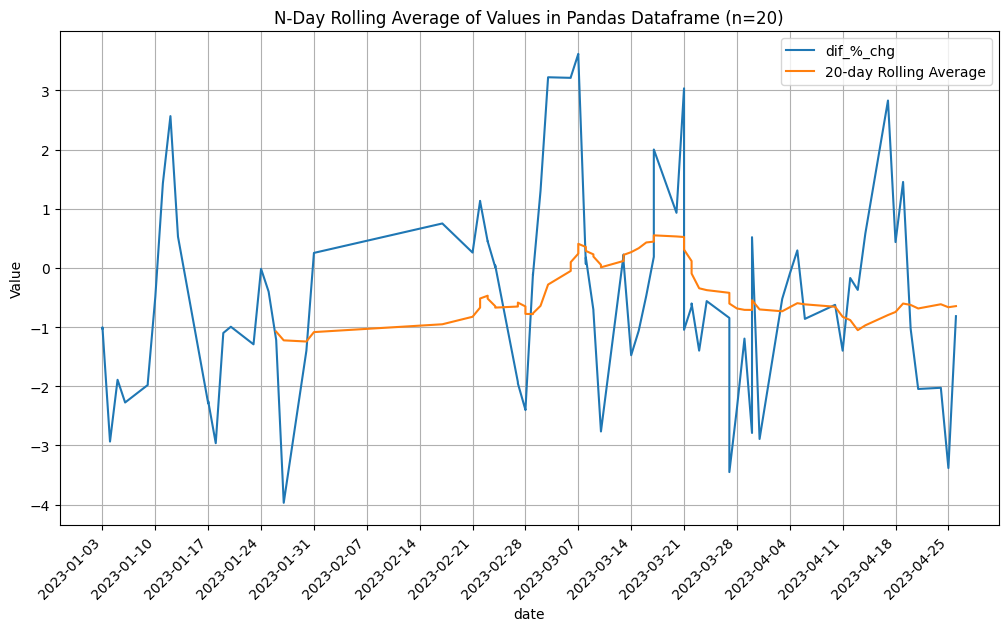

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


df = df_picks_mp.copy()

# Sort the dataframe by date
df = df.sort_values(by="date")
# df =df.tail(round(252*.15))

date_start = '2023-01-01'
date_end = '2023-05-01'

# Select data between dates (inclusive)
df = df[(df['date'] >= date_start) & (df['date'] <= date_end)]


# Define the n-day rolling average window
n_day_window = 20

# Calculate the n-day rolling average
df["Rolling Average"] = df["dif_%_chg"].rolling(window=n_day_window).mean()
df

df['date'] = pd.to_datetime(df['date'])
# df['date'] = df['date'].dt.tz_localize('UTC').dt.tz_convert('utc')
df['date'].dt.strftime('%Y-%m-%d')

# Plot the dataframe
plt.figure(figsize=(10, 6))
plt.plot(df["date"], df["dif_%_chg"], label="dif_%_chg")
plt.plot(df["date"], df["Rolling Average"], label=f"{n_day_window}-day Rolling Average")
# plt.xlabel("date")


# Set major locator to weekly intervals
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

# Format date labels in 'yyyy-mm-dd' format
date_form = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_form)

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust spacing for better fit
plt.xlabel("date")

plt.ylabel("Value")
plt.title(f"N-Day Rolling Average of Values in Pandas Dataframe (n={n_day_window})")
plt.legend()
plt.grid(True)
plt.show()

In [48]:
plt.xticks

<function matplotlib.pyplot.xticks(ticks=None, labels=None, *, minor=False, **kwargs)>

In [49]:
df

,date,days_lookback,syms_freq,symbols,date_buy,sh_portf_buy,$_portf_buy,sh_SPY_buy,$_SPY_buy,date_sell,sh_portf_sell,$_portf_sell,%_portf_chg,sh_SPY_sell,$_SPY_sell,%_SPY_chg,dif_%_chg,win,Rolling Average
364,2023-01-03,"[15, 30, 60, 120]",sym_freq_12,['SHV'],2023-01-04,[9.0],943.834694,[2.0],756.029419,2023-01-09,[9.0],944.263916,0.045476,[2.0],764.106567,1.068364,-1.022888,0,NaN
363,2023-01-03,"[30, 60, 120]",sym_freq_9,"['FTSM', 'SHV']",2023-01-04,"[8.0, 4.0]",873.662354,[2.0],756.029419,2023-01-09,"[8.0, 4.0]",874.234955,0.065540,[2.0],764.106567,1.068364,-1.002824,0,NaN
362,2023-01-04,"[30, 60, 120]",sym_freq_9,['SHV'],2023-01-05,[9.0],944.006493,[2.0],747.400513,2023-01-10,[9.0],944.178154,0.018184,[2.0],769.465149,2.952184,-2.933999,0,NaN
361,2023-01-05,"[30, 60, 120]",sym_freq_9,['SHV'],2023-01-06,[9.0],944.178154,[2.0],764.540039,2023-01-11,[9.0],944.435646,0.027272,[2.0],779.197266,1.917130,-1.889858,0,NaN
360,2023-01-06,"[30, 60, 120]",sym_freq_9,['SHV'],2023-01-09,[9.0],944.263916,[2.0],764.106567,2023-01-12,[9.0],944.950836,0.072747,[2.0],782.034058,2.346203,-2.273456,0,NaN
359,2023-01-09,"[30, 60, 120]",sym_freq_8,['FTSM'],2023-01-10,[17.0],966.106789,[2.0],769.465149,2023-01-13,[17.0],966.593811,0.050411,[2.0],785.067993,2.027752,-1.977341,0,NaN
358,2023-01-09,"[30, 60, 120]",sym_freq_9,['SHV'],2023-01-10,[9.0],944.178154,[2.0],769.465149,2023-01-13,[9.0],944.950836,0.081836,[2.0],785.067993,2.027752,-1.945915,0,NaN
357,2023-01-10,"[30, 60, 120]",sym_freq_8,['SHV'],2023-01-11,[9.0],944.435646,[2.0],779.197266,2023-01-17,[9.0],945.208328,0.081814,[2.0],783.629822,0.568862,-0.487048,0,NaN
356,2023-01-11,"[30, 60, 120]",sym_freq_9,"['FTSM', 'SHV']",2023-01-12,"[8.0, 4.0]",874.845825,[2.0],782.034058,2023-01-18,"[8.0, 4.0]",875.304047,0.052377,[2.0],771.257935,-1.377961,1.430338,1,NaN
355,2023-01-12,"[30, 60, 120]",sym_freq_9,"['FTSM', 'SHV']",2023-01-13,"[8.0, 4.0]",874.845825,[2.0],785.067993,2023-01-19,"[8.0, 4.0]",875.647614,0.091649,[2.0],765.643311,-2.474268,2.565917,1,NaN


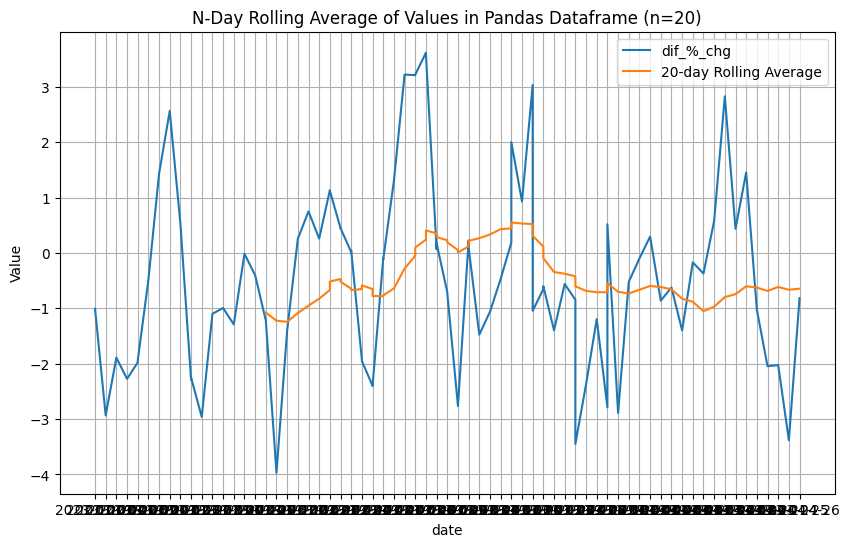

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_picks_mp.copy()

# Sort the dataframe by date
df = df.sort_values(by="date")
# df =df.tail(round(252*.15))

date_start = '2023-01-01'
date_end = '2023-05-01'

# Select data between dates (inclusive)
df = df[(df['date'] >= date_start) & (df['date'] <= date_end)]


# Define the n-day rolling average window
n_day_window = 20

# Calculate the n-day rolling average
df["Rolling Average"] = df["dif_%_chg"].rolling(window=n_day_window).mean()
df

# Plot the dataframe
plt.figure(figsize=(10, 6))
plt.plot(df["date"], df["dif_%_chg"], label="dif_%_chg")
plt.plot(df["date"], df["Rolling Average"], label=f"{n_day_window}-day Rolling Average")
plt.xlabel("date")
plt.ylabel("Value")
plt.title(f"N-Day Rolling Average of Values in Pandas Dataframe (n={n_day_window})")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
df.tail(100)

,date,days_lookback,syms_freq,symbols,date_buy,sh_portf_buy,$_portf_buy,sh_SPY_buy,$_SPY_buy,date_sell,sh_portf_sell,$_portf_sell,%_portf_chg,sh_SPY_sell,$_SPY_sell,%_SPY_chg,dif_%_chg,win,Rolling Average
99,2023-10-12,"[30, 60, 120]",sym_freq_9,"['FTSM', 'SHV']",2023-10-13,"[8.0, 4.0]",905.932709,[2.0],859.515198,2023-10-18,"[8.0, 4.0]",905.893066,-0.004376,[2.0],856.945557,-0.298964,0.294588,1,0.172138
98,2023-10-13,"[15, 30, 60, 120]",sym_freq_12,['SHV'],2023-10-16,[9.0],979.397438,[2.0],868.558533,2023-10-19,[9.0],980.019196,0.063484,[2.0],849.416077,-2.203934,2.267418,1,0.467377
97,2023-10-13,"[30, 60, 120]",sym_freq_9,"['FTSM', 'SHV']",2023-10-16,"[8.0, 4.0]",905.893127,[2.0],868.558533,2023-10-19,"[8.0, 4.0]",906.327484,0.047948,[2.0],849.416077,-2.203934,2.251882,1,0.889212
96,2023-10-16,"[30, 60, 120]",sym_freq_9,"['FTSM', 'SHV']",2023-10-17,"[8.0, 4.0]",905.893127,[2.0],868.518677,2023-10-20,"[8.0, 4.0]",906.603912,0.078462,[2.0],838.978455,-3.401219,3.479681,1,1.555978
95,2023-10-17,"[30, 60, 120]",sym_freq_9,"['FTSM', 'SHV']",2023-10-18,"[8.0, 4.0]",905.893066,[2.0],856.945557,2023-10-23,"[8.0, 4.0]",906.919922,0.113353,[2.0],837.524292,-2.266336,2.379689,1,2.134652
94,2023-10-18,"[30, 60, 120]",sym_freq_9,"['FTSM', 'SHV']",2023-10-19,"[8.0, 4.0]",906.327484,[2.0],849.416077,2023-10-24,"[8.0, 4.0]",906.959412,0.069724,[2.0],843.838745,-0.656608,0.726332,1,2.221000
93,2023-10-19,"[15, 30, 60, 120]",sym_freq_12,['SHV'],2023-10-20,[9.0],980.285683,[2.0],838.978455,2023-10-25,[9.0],980.552170,0.027185,[2.0],831.727783,-0.864226,0.891411,1,1.945799
92,2023-10-19,"[30, 60, 120]",sym_freq_9,"['FTSM', 'SHV']",2023-10-20,"[8.0, 4.0]",906.603912,[2.0],838.978455,2023-10-25,"[8.0, 4.0]",906.880402,0.030497,[2.0],831.727783,-0.864226,0.894723,1,1.674367
91,2023-10-20,"[30, 60, 120]",sym_freq_9,"['FTSM', 'SHV']",2023-10-23,"[8.0, 4.0]",906.919922,[2.0],837.524292,2023-10-26,"[8.0, 4.0]",907.512299,0.065317,[2.0],821.768188,-1.881271,1.946589,1,1.367749
89,2023-10-23,"[30, 60, 120]",sym_freq_9,"['FTSM', 'SHV']",2023-10-24,"[8.0, 4.0]",906.959412,[2.0],843.838745,2023-10-27,"[8.0, 4.0]",907.630676,0.074013,[2.0],818.043274,-3.056920,3.130932,1,1.517997
